# Two Normal Dist. test for Diffusion Model in 1D
測試：生成兩種不同的Nomal distribution N(5,2),加噪去噪以後還會變成原來的兩個不同分布


In [ ]:
import torch, numpy as np
import math, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy import stats
from collections import deque

DEVICE        = 'cpu' 
T             = 500        # diffusion steps
BATCH_SIZE    = 512
TRAIN_ITERS   = 2000       # 訓練步數
LR            = 5e-4
HIDDEN        = 512
TIME_DIM      = 64
N_TRAIN_SAMP  = 10000       # 訓練資料量）


In [5]:
### Constants setting
betas = torch.linspace(1e-4, 0.02, T+1, device=DEVICE)
alphas = 1.0-betas
abar = torch.cumprod(alphas, dim=0)
sqrt_abar = torch.sqrt(abar)
sqrt_lmabar = torch.sqrt(1.0-abar)
sqrt_rcp_a = torch.sqrt(1.0 / alphas)

### 這塊留給 time embedding
#-------------------------
def sinusoidal_time_emb(t, dim):
    # t: (B,) 的整數 timestep
    device = t.device
    t = t.float().unsqueeze(1)  # (B,1)
    half = dim // 2
    freqs = torch.exp(
        torch.arange(half, device=device).float() * (-math.log(10000.0) / max(1, half-1))
    )  # (half,)
    angles = t * freqs  # (B,half)
    emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=1)  # (B, 2*half)
    if dim % 2 == 1:  # 補一維避免奇數維崩
        emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=1)
    return emb  # (B, dim)

In [6]:
## 建nn
class EpsMLP(nn.Module):
    def __init__(self, hidden=HIDDEN, time_dim=TIME_DIM):
        super().__init__()
        self.time_dim = time_dim
        # 把 time embedding 投影到hidden layer
        self.t_proj = nn.Sequential(
            nn.Linear(time_dim, hidden), 
            nn.SiLU()
            )
        
        # y_t(1維) + time(hidden) → hidden → 1維噪聲預測
        in_dim = hidden + 1 # y+dim=1
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden,1)
        )
    def forward(self, y_t, t):
        t_emb = sinusoidal_time_emb(t, self.time_dim)   # (B, time_dim)
        h_t = self.t_proj(t_emb)                        # (B, hidden)
        h = torch.cat([y_t, h_t], dim=1)                # (B, 1+hidden)
        return self.net(h)

model = EpsMLP().to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=TRAIN_ITERS, eta_min=1e-5)  ###<---10/1新增

In [10]:
### 計算 y_t= sqrt(abar_t) y0 + sqrt(1-abar_t) * eps
# ---------------------
def q_sample(y0, t, eps=None):
    if eps is None:
        eps = torch.randn_like(y0)   ## 產生跟y0大小一樣的初始normal雜訊
    sa = sqrt_abar[t].view(-1,1)
    som = sqrt_lmabar[t].view(-1,1)
    return sa*y0+som*eps, eps

In [11]:
### ===============================
### ALGORITHM 1
### ===============================

def train_loop(record_step):
    model.train()
    losses =[]
    movavg =[]
    ma=deque(maxlen=50) #長度為50的mov_avg frame

    for step in range(1, TRAIN_ITERS+1):
        # 取 y0~N(0,1)
        y0 = torch.randn(BATCH_SIZE, 1, device=DEVICE)
        # 隨機time step
        t = torch.randint(2,T+1, (BATCH_SIZE,),device=DEVICE).long()
        # 向前加噪
        y_t, eps = q_sample(y0,t)
        # 預測噪音
        eps_hat = model(y_t, t)     
        loss = F.mse_loss(eps_hat, eps)

        opt.zero_grad(set_to_none = True) 
        loss.backward()
        #把L2norm限制在1.0以內避免梯度爆炸 ; 但如果loss穩定可以不用
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        if step % record_step ==0: 
            val = loss.detach().item()
            losses.append(val)
            ma.append(val)
            movavg.append(sum(ma)/len(ma))
            print(f"[train] step {step:4d} | loss {loss.item():.6f}")
    
    
    return losses, movavg

In [ ]:
### ===============================
### ALGORITHM 2
### ===============================

@torch.no_grad()
def sample_on_grid(n_points = 401):
    model.eval()
    # 初始化 y 的 batch，要用 n_points
    y = torch.randn(n_points, 1, device=DEVICE)  ## 直接在N(0,1)裡面抽東西就好
    for t in reversed(range(T+1)):
        tb = torch.full((n_points,), t, device=DEVICE, dtype=torch.long)
        eps_hat = model(y, tb) 
        mean = sqrt_rcp_a[t]*(y - (betas[t]/sqrt_lmabar[t]) * eps_hat) #那行公式
        if t>0:
            y = mean + torch.sqrt(betas[t])*torch.randn_like(y)
        
    
    return y.squeeze(1).cpu() 

## Test area 
※這個部分先參照 gpt作法，但其中有幾個點需要再確認：
1. 是否有訓練到？看起來是gpt又自己生成了演算法(加噪去噪)
2. 

In [15]:
# ========= 1) 生成兩群常態資料 =========
def make_two_normals(n_each=5000, mu1=0.0, var1=1.0, mu2=5.0, var2=2.0, device='cpu'):
    x1 = torch.randn(n_each, 1, device=device) * (var1**0.5) + mu1
    x2 = torch.randn(n_each, 1, device=device) * (var2**0.5) + mu2
    return x1, x2

# ========= 2) 前向擴散（加噪） =========
@torch.no_grad()
def forward_diffuse(x0, t):
    """
    x0: (N,1), t: int 或 長度為 N 的 LongTensor (1..T)
    回傳 x_t 與當次用到的 eps
    """
    if not torch.is_tensor(t):
        t = torch.full((x0.shape[0],), int(t), device=x0.device, dtype=torch.long)
    eps = torch.randn_like(x0)
    x_t = sqrt_abar[t].unsqueeze(1) * x0 + sqrt_lmabar[t].unsqueeze(1) * eps
    return x_t, eps

# ========= 3) 反向擴散（去噪）從 t_start -> 0 =========
@torch.no_grad()
def denoise_from_t(model, x_t, t_start):
    """
    用訓練好的 model，從 t_start 一路 denoise 到 0
    """
    model.eval()
    n = x_t.shape[0]
    for t in range(int(t_start), 0, -1):
        tt = torch.full((n,), t, device=x_t.device, dtype=torch.long)
        eps_hat = model(x_t, tt)

        a_t   = alphas[t]
        abar_t = abar[t]
        beta_t = betas[t]
        abar_tm1 = abar[t-1] if t > 1 else torch.tensor(1.0, device=x_t.device)

        beta_tilde = (1 - abar_tm1) / (1 - abar_t) * beta_t
        mean = (1.0/torch.sqrt(a_t)) * (x_t - (beta_t/torch.sqrt(1-abar_t)) * eps_hat)

        if t > 1:
            x_t = mean + torch.sqrt(beta_tilde) * torch.randn_like(x_t)
        else:
            x_t = mean
    return x_t  # 近似 x_0




In [16]:
# ========= 4) 視覺化 & 檢定工具 =========
def ecdf(a: np.ndarray):
    s = np.sort(a)
    n = s.size
    y = np.arange(1, n+1)/n
    return s, y

def compare_two_groups(title, a, b):
    a_np = a.detach().flatten().cpu().numpy()
    b_np = b.detach().flatten().cpu().numpy()

    # KS / t-test / Levene
    ks_stat, ks_p = stats.ks_2samp(a_np, b_np)
    tt_stat, tt_p = stats.ttest_ind(a_np, b_np, equal_var=False)
    lv_stat, lv_p = stats.levene(a_np, b_np)

    print(f"\n=== {title} ===")
    print(f"mean: {a_np.mean():.3f} vs {b_np.mean():.3f}")
    print(f"std : {a_np.std(ddof=1):.3f} vs {b_np.std(ddof=1):.3f}")
    print(f"KS   : stat={ks_stat:.4f}, p={ks_p:.4f}")
    print(f"t-test(means): stat={tt_stat:.4f}, p={tt_p:.4f}")
    print(f"Levene(vars) : stat={lv_stat:.4f}, p={lv_p:.4f}")

    xs, Fx = ecdf(a_np); ys, Fy = ecdf(b_np)
    plt.figure(figsize=(7,4.5))
    plt.step(xs, Fx, where="post", label="group A")
    plt.step(ys, Fy, where="post", label="group B")
    plt.xlabel("value"); plt.ylabel("empirical CDF")
    plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()


=== Original x0: A vs B ===
mean: 0.002 vs 4.969
std : 0.995 vs 1.406
KS   : stat=0.9646, p=0.0000
t-test(means): stat=-203.8653, p=0.0000
Levene(vars) : stat=473.1623, p=0.0000


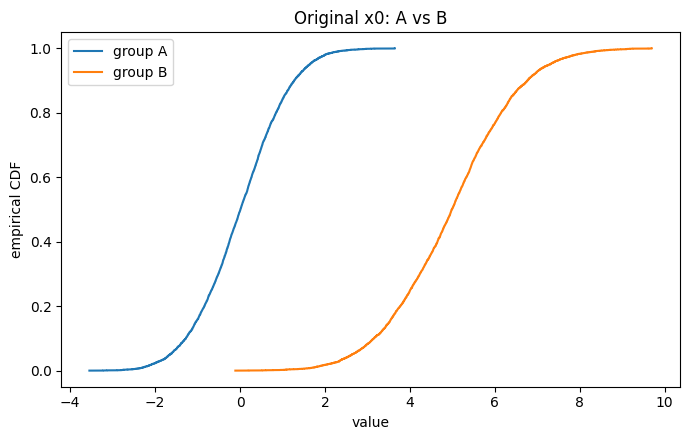


=== Denoise from T: A vs B (expect ~indistinguishable) ===
mean: 0.384 vs 5.908
std : 18.209 vs 18.060
KS   : stat=0.1372, p=0.0000
t-test(means): stat=-15.2289, p=0.0000
Levene(vars) : stat=0.3196, p=0.5719


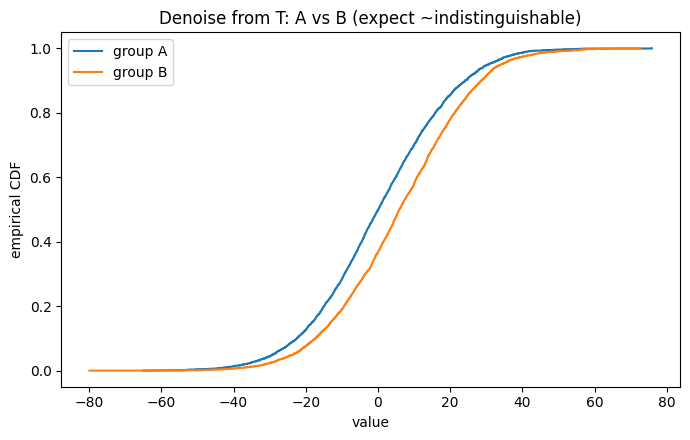


=== Denoise from t=50: A vs B (should remain different) ===
mean: 0.020 vs 4.980
std : 1.050 vs 1.447
KS   : stat=0.9578, p=0.0000
t-test(means): stat=-196.1588, p=0.0000
Levene(vars) : stat=424.7222, p=0.0000


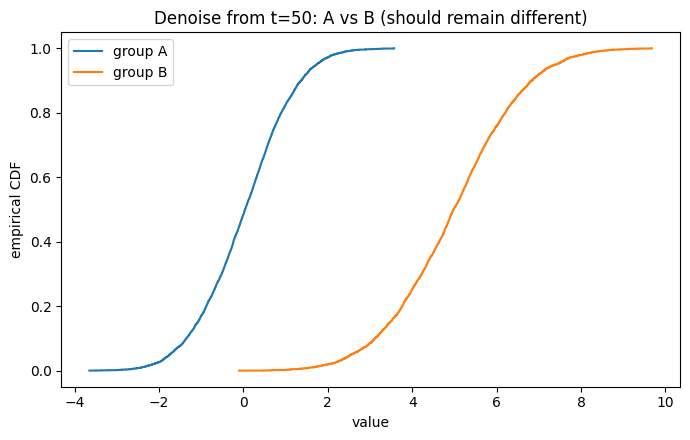

In [17]:
# ========= 5) 實驗：完整去噪 vs 局部去噪 =========
# 兩群分佈（你說的 N(5,2) 我這裡解讀為 mean=5, variance=2；另一群自選）
xA0, xB0 = make_two_normals(n_each=5000, mu1=0.0, var1=1.0, mu2=5.0, var2=2.0, device=DEVICE)

# (a) 原始分佈比較（應該顯著不同）
compare_two_groups("Original x0: A vs B", xA0, xB0)

# (b) 完整擴散到 T 再去噪回 0（情報遺失 → 會變成混合分佈）
xAT, _ = forward_diffuse(xA0, T)     # 先 forward 到 T
xBT, _ = forward_diffuse(xB0, T)
xA_recon_full = denoise_from_t(model, xAT, T)
xB_recon_full = denoise_from_t(model, xBT, T)
compare_two_groups("Denoise from T: A vs B (expect ~indistinguishable)", xA_recon_full, xB_recon_full)

# (c) 只擴散到小 t 再去噪（保留部分訊息 → 仍可分）
t_small = max(1, T//10)               # 例如 10% 的噪聲深度
xAt, _ = forward_diffuse(xA0, t_small)
xBt, _ = forward_diffuse(xB0, t_small)
xA_recon_partial = denoise_from_t(model, xAt, t_small)
xB_recon_partial = denoise_from_t(model, xBt, t_small)
compare_two_groups(f"Denoise from t={t_small}: A vs B (should remain different)", xA_recon_partial, xB_recon_partial)


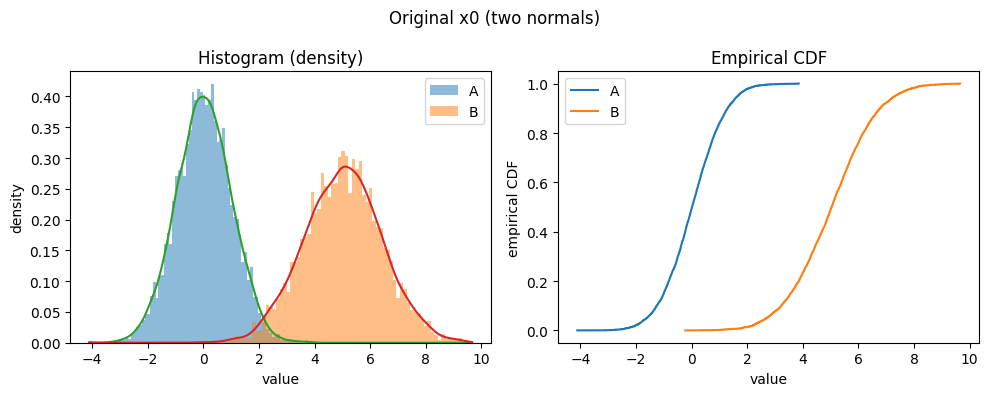

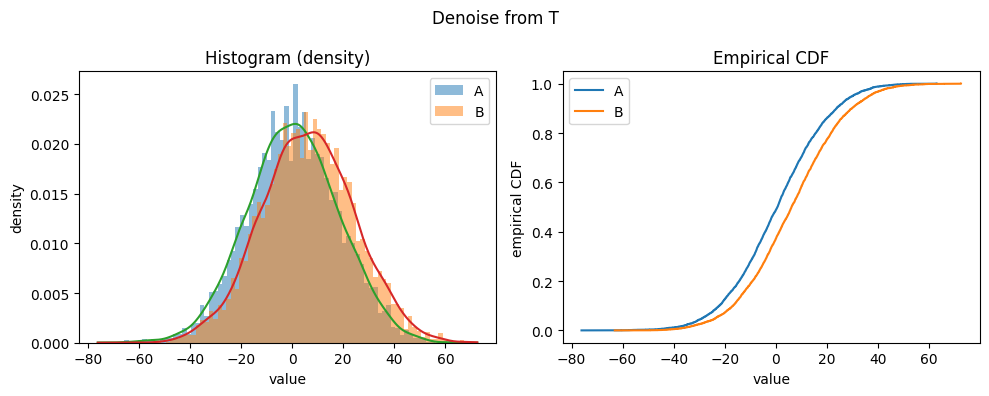

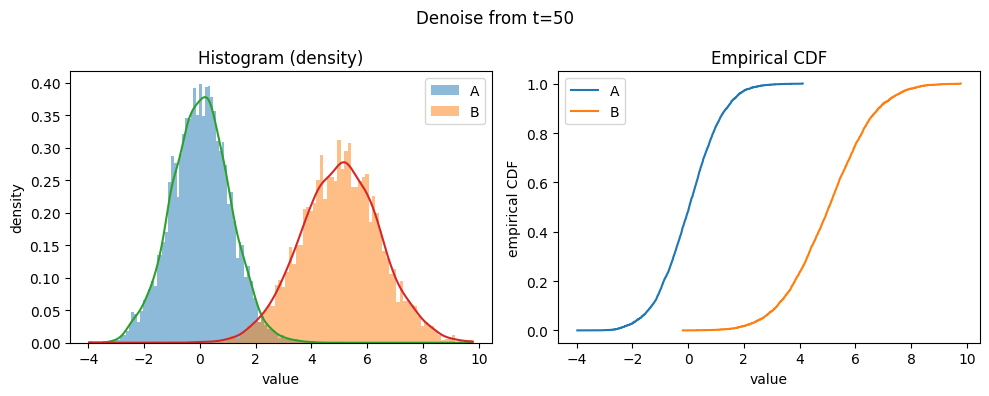

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def _to_np(x):
    # 支援 torch.Tensor 或 numpy
    try:
        import torch
        if isinstance(x, torch.Tensor):
            return x.detach().flatten().cpu().numpy()
    except Exception:
        pass
    return np.asarray(x).ravel()

def ecdf_np(a):
    s = np.sort(a)
    n = s.size
    return s, np.arange(1, n+1)/n

def plot_two_dist(a, b, title="A vs B", bins=80):
    A = _to_np(a); B = _to_np(b)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # 直方圖（密度）
    ax[0].hist(A, bins=bins, density=True, alpha=0.5, label="A")
    ax[0].hist(B, bins=bins, density=True, alpha=0.5, label="B")
    # 可選：KDE 平滑（失敗就略過）
    try:
        xs = np.linspace(min(A.min(), B.min()), max(A.max(), B.max()), 400)
        ax[0].plot(xs, stats.gaussian_kde(A)(xs))
        ax[0].plot(xs, stats.gaussian_kde(B)(xs))
    except Exception:
        pass
    ax[0].set_title("Histogram (density)")
    ax[0].set_xlabel("value"); ax[0].set_ylabel("density"); ax[0].legend()

    # ECDF
    xA, FA = ecdf_np(A); xB, FB = ecdf_np(B)
    ax[1].step(xA, FA, where="post", label="A")
    ax[1].step(xB, FB, where="post", label="B")
    ax[1].set_title("Empirical CDF")
    ax[1].set_xlabel("value"); ax[1].set_ylabel("empirical CDF"); ax[1].legend()

    fig.suptitle(title)
    fig.tight_layout()
    plt.show()


# 原始兩個分布
plot_two_dist(xA0, xB0, title="Original x0 (two normals)")

# 完整擴散到 T 再去噪
plot_two_dist(xA_recon_full, xB_recon_full, title="Denoise from T")

# 只擴散到較小 t 再去噪
plot_two_dist(xA_recon_partial, xB_recon_partial, title=f"Denoise from t={t_small}")
